In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import face_alignment # version 1.4.1

import mediapipe as mp # version 0.10.15
from mediapipe.tasks import python
from mediapipe.tasks.python import vision



## Dlib landmark detector
dlib_detector = face_alignment.FaceAlignment(face_alignment.LandmarksType.THREE_D, flip_input=False) # New: THREE_D

def draw_dlib_landmarks_on_image(rgb_image, landmarks, color=(0, 0, 255)):
    annotated_image = np.copy(rgb_image)

    # Draw the facial landmarks
    for loc in landmarks:
        x = int(loc[0]); y = int(loc[1])
        cv2.circle(annotated_image, (x, y), 5, color, -1)

    # Optionally, you can label each landmark
    # for idx, (x, y) in enumerate(landmarks):
    #     cv2.putText(image, str(idx + 1), (x - 5, y - 5),
    #                 cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 255), 1)

    return annotated_image




## Download the Mediapipe face landmark model first
#!wget -O ./face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

## Mediapipe face landmark detector
base_options = python.BaseOptions(model_asset_path='./face_landmarker_v2_with_blendshapes.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
mp_detector = vision.FaceLandmarker.create_from_options(options)


from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
def draw_mediapipe_landmarks_on_image(rgb_image, detection_result):
    face_landmarks_list = detection_result.face_landmarks
    annotated_image = np.copy(rgb_image)

    # Loop through the detected faces to visualize.
    for idx in range(len(face_landmarks_list)):
        face_landmarks = face_landmarks_list[idx]

        # Draw the face landmarks.
        face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
        face_landmarks_proto.landmark.extend([
          landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
        ])

        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp.solutions.drawing_styles
              .get_default_face_mesh_iris_connections_style())

    return annotated_image






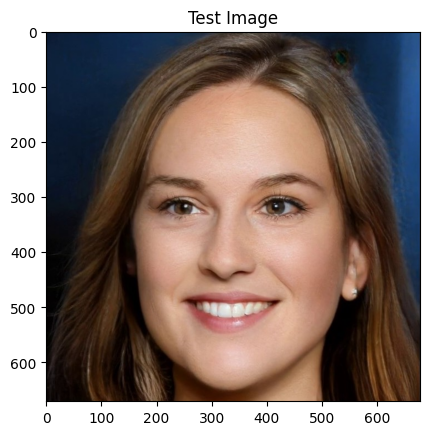

In [2]:
# Load test image
img = cv2.imread('./test_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img); plt.title('Test Image'); plt.show()


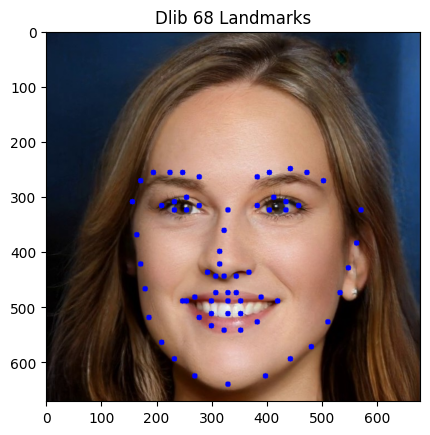

In [3]:
# Detect landmarks using Dlib
lmks_dlib = dlib_detector.get_landmarks(img)[0][:,:2]

# Plot the landmarks
lmks_img_dlib = draw_dlib_landmarks_on_image(img, lmks_dlib, color=(0,0,255))
plt.imshow(lmks_img_dlib); plt.title('Dlib 68 Landmarks'); plt.show()

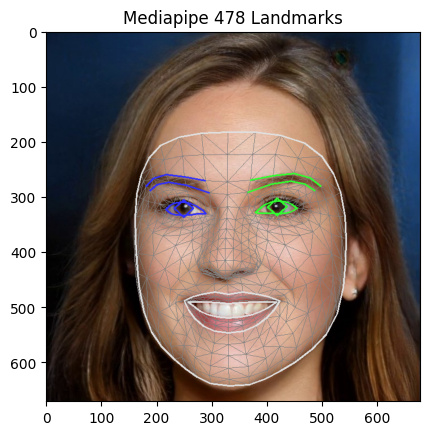

In [4]:
# Detect landmarks using Mediapipe
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img) # convert numpy image to Mediapipe Image
mp_detection_result = mp_detector.detect(image)
lmks_mp = mp_detection_result.face_landmarks[0] # the first detected face
lmks_mp = np.array(list(map(lambda l: np.array([l.x, l.y]), lmks_mp)))
lmks_mp[:, 0] = lmks_mp[:, 0] * img.shape[1]
lmks_mp[:, 1] = lmks_mp[:, 1] * img.shape[0]

# Plot the landmarks
lmks_img_mp = draw_mediapipe_landmarks_on_image(image.numpy_view(), mp_detection_result)
plt.imshow(lmks_img_mp); plt.title('Mediapipe 478 Landmarks'); plt.show()

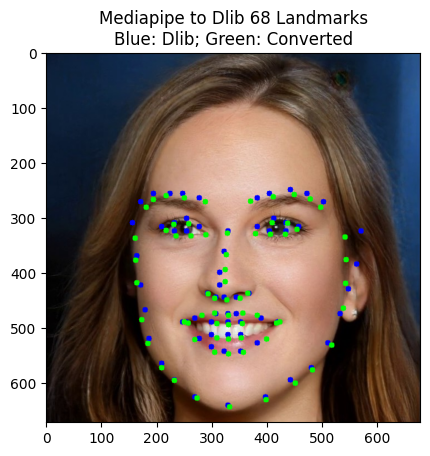

In [5]:
from mp2dlib import convert_landmarks_mediapipe_to_dlib


# Plot the landmarks
lmks_mp2dlib = convert_landmarks_mediapipe_to_dlib(lmks_mp)
lmks_img_mp2dlib = draw_dlib_landmarks_on_image(lmks_img_dlib, lmks_mp2dlib, color=(0,255,0))
plt.imshow(lmks_img_mp2dlib); plt.title('Mediapipe to Dlib 68 Landmarks\nBlue: Dlib; Green: Converted'); plt.show()
